In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
train = pd.read_csv('/home/rafael/git/covid19/datasets/global-week-2/train.csv')
test = pd.read_csv('/home/rafael/git/covid19/datasets/global-week-2/test.csv')
subm = pd.read_csv('/home/rafael/git/covid19/datasets/global-week-2/submission.csv')

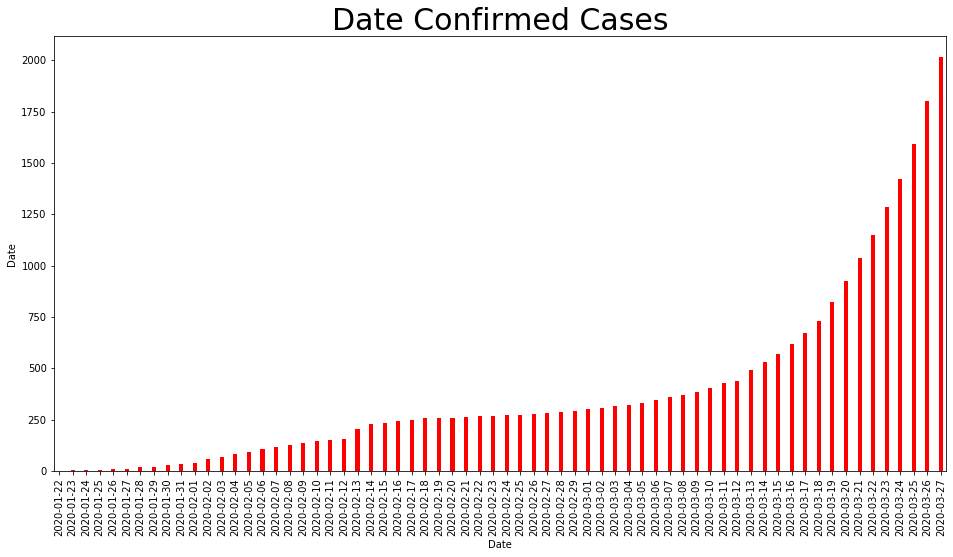

In [3]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
train.groupby('Date').mean().sort_values(by='ConfirmedCases')['ConfirmedCases'].plot(
                                            'bar', color='r',width=0.3,title='Date Confirmed Cases', fontsize=10)
plt.xticks(rotation = 90)
plt.ylabel('Date')
ax.title.set_fontsize(30)
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(10)

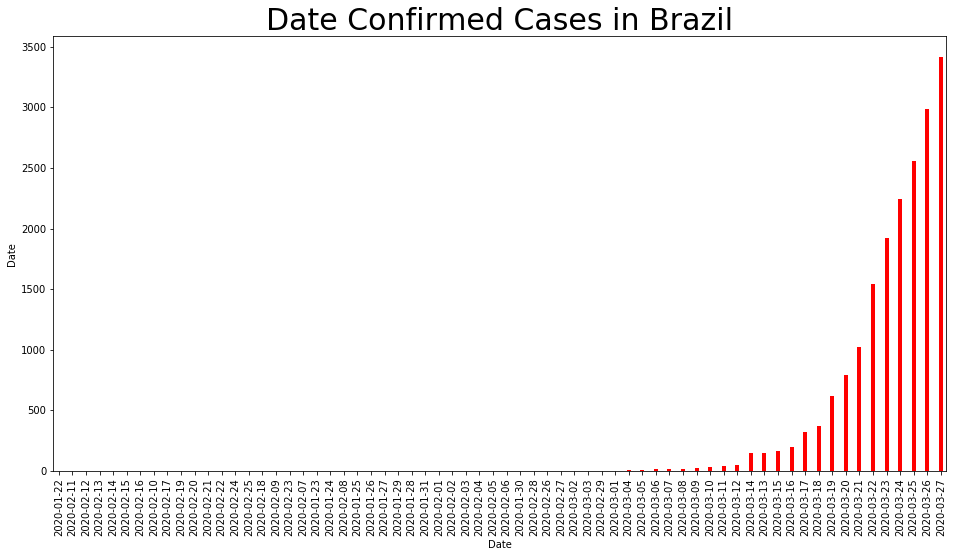

In [4]:
df_br = train[train['Country_Region'] == 'Brazil']
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
df_br.groupby('Date').mean().sort_values(by='ConfirmedCases')['ConfirmedCases'].plot(
                        'bar', color='r',width=0.3,title='Date Confirmed Cases in Brazil', fontsize=10)
plt.xticks(rotation = 90)
plt.ylabel('Date')
ax.title.set_fontsize(30)
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(10)

In [5]:
train = train[['Country_Region', 'Date', 'ConfirmedCases', 'Fatalities']]

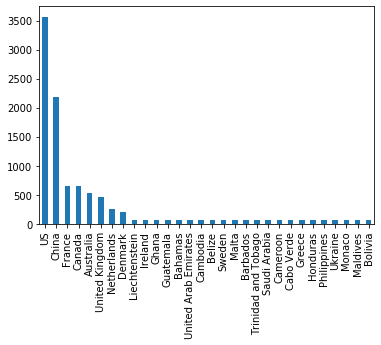

In [6]:
train.Country_Region.value_counts()[0:30].plot(kind='bar')
plt.show()

In [7]:
confir_case_br = train[train['Country_Region']=='Brazil'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_br = train[train['Country_Region']=='Brazil'].groupby(['Date']).agg({'Fatalities':['sum']})
total_br = confir_case_br.join(fatalities_br)



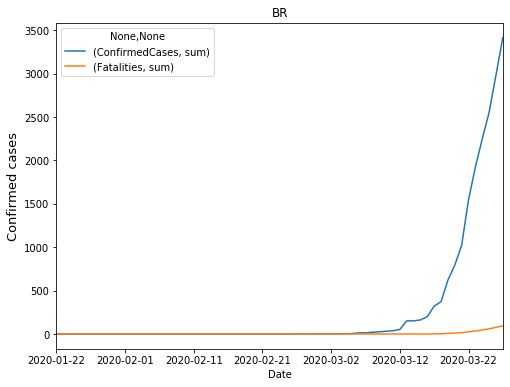

In [8]:
plt.figure(figsize=(8,6))
total_br.plot(ax=plt.gca(), title='BR')
plt.ylabel('Confirmed cases', size=13)

plt.show()

# Data Transformation

In [9]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(train['Date'])

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19404 entries, 0 to 19403
Data columns (total 4 columns):
Country_Region    19404 non-null object
Date              19404 non-null datetime64[ns]
ConfirmedCases    19404 non-null float64
Fatalities        19404 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 606.5+ KB


In [11]:
train['Date'] = train['Date'].astype('int64')
test['Date'] = test['Date'].astype('int64')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19404 entries, 0 to 19403
Data columns (total 4 columns):
Country_Region    19404 non-null object
Date              19404 non-null int64
ConfirmedCases    19404 non-null float64
Fatalities        19404 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 606.5+ KB


In [13]:
train

,Country_Region,Date,ConfirmedCases,Fatalities
0,Afghanistan,1579651200000000000,0.0,0.0
1,Afghanistan,1579737600000000000,0.0,0.0
2,Afghanistan,1579824000000000000,0.0,0.0
3,Afghanistan,1579910400000000000,0.0,0.0
4,Afghanistan,1579996800000000000,0.0,0.0
...,...,...,...,...
19399,Zimbabwe,1584921600000000000,3.0,1.0
19400,Zimbabwe,1585008000000000000,3.0,1.0
19401,Zimbabwe,1585094400000000000,3.0,1.0
19402,Zimbabwe,1585180800000000000,3.0,1.0


# Iniciando previsões

In [14]:
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [15]:
le = LabelEncoder()
def FuncLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df

In [16]:
train.head(2)

,Country_Region,Date,ConfirmedCases,Fatalities
0,Afghanistan,1579651200000000000,0.0,0.0
1,Afghanistan,1579737600000000000,0.0,0.0


In [17]:
train = FuncLabelEncoder(train)
train.iloc[235:300,:]

,Country_Region,Date,ConfirmedCases,Fatalities
235,3,1582848000000000000,0.0,0.0
236,3,1582934400000000000,0.0,0.0
237,3,1583020800000000000,0.0,0.0
238,3,1583107200000000000,1.0,0.0
239,3,1583193600000000000,1.0,0.0
...,...,...,...,...
295,4,1582329600000000000,0.0,0.0
296,4,1582416000000000000,0.0,0.0
297,4,1582502400000000000,0.0,0.0
298,4,1582588800000000000,0.0,0.0


In [18]:
test = FuncLabelEncoder(test)
test

,ForecastId,Province_State,Country_Region,Date
0,1,125,0,1579651200000000000
1,2,125,0,1579737600000000000
2,3,125,0,1579824000000000000
3,4,125,0,1579910400000000000
4,5,125,0,1579996800000000000
...,...,...,...,...
12637,12638,125,172,1582329600000000000
12638,12639,125,172,1582416000000000000
12639,12640,125,172,1582502400000000000
12640,12641,125,172,1582588800000000000


In [19]:
# Selecionando features e target
features = ['Date', 'Country_Region']
target = 'ConfirmedCases'

In [20]:
train[features].head()

,Date,Country_Region
0,1579651200000000000,0
1,1579737600000000000,0
2,1579824000000000000,0
3,1579910400000000000,0
4,1579996800000000000,0


# Confirmed Cases

In [ ]:
rfcla = RandomForestClassifier(n_estimators=100, random_state=1)
rfcla.fit(train[features], train[target])

In [22]:
predictions = rfcla.predict(test[features])

In [23]:
predictions

array([0., 0., 0., ..., 0., 0., 0.])

# Fatalities

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
features1 = ['Date', 'Country_Region']
target1 = 'Fatalities'

In [27]:
rfcla1 = RandomForestClassifier(n_estimators=100, random_state=1)
rfcla1.fit(train[features1], train[target1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [28]:
predictions1 = rfcla.predict(test[features1])